# Academic access for Twitter API v2


As listed on the Twitter docs, you should qualify under the following use case: "Affiliated with an academic institution AND have a clearly defined project".

However, last year, we had mixed success getting students approved for academic access to the Twitter API, with seemingly arbitrary denials from Twitter for some students. 

A couple of issues we ran into:

1. Twitter requires a well-defined research project description to apply. 
1. You also need a link to a public student directory website or a Google Scholar page, so that Twitter can verify your identity. 

**My recommendation** is that if you'd like to use the Twitter API for the final project, then you should wait to apply for academic access until your project proposal is finished. 

You can apply for academic access using [this page](https://developer.twitter.com/en/portal/petition/academic/is-it-right-for-you). More information about the application process is available at [this link](https://developer.twitter.com/en/products/twitter-api/academic-research/application-info).


Once you have academic access you should see "ACADEMIC" listed on https://developer.twitter.com/en/portal/dashboard.

<div>
    <img src="imgs/twitter-api-1.png" width=500/>
</div>

With academic access in v2, the new limits for the search API are significantly more than permissive than with v1 access. There are two search endpoints:

1. `client.search_recent_tweets()` [docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_recent_tweets): Search one recent tweets within the last 7 days, 
1. `client.search_all_tweets()` [docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets): Search all historical tweets going back to 2006. 

<div>
    <img src="imgs/twitter-api-2.png" width=700 />
</div>

For historical search, you are allowed 300 requests per every 15 minutes, and can access 500 tweets per requests, so you can pull 150,000 tweets per every 15 minutes. The required wait time between requests is one second. 


## References

- [Tutorial on tweepy with v2 API](https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9) -- **very good tutorial, definitely read this**
- [Twitter search API documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction)
- [Search query operators](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product)

In [1]:
import tweepy as tw
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import calendar

In [2]:
print(tw.__version__) # Make sure this is > 4.0

4.10.1


In [3]:
# Get this from the app that you create on the developer portal
BEARER_TOKEN = ""

In [4]:
# Initialize the API client and tell tweepy to wait if rate limit is met
client = tw.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)

## 1. Historical tweets for a specified time period

Below, we select all tweets with the hashtag "phillies" during calendar year 2020 and exclude any retweets.

In [5]:
# Search for phillies hashtag and remove retweets
query = "#phillies -is:retweet" # remove retweets using hypen

# Example start and end date
start_date = datetime.strptime("2020-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2020-12-31", "%Y-%m-%d")

In [6]:
results = []
max_results_per_request = 500 # must be between 10 and 500

# Use the paginator to loop over all available tweets in batches of 500
# This pulls 500 tweets at a time until all tweets from the time period are pulled
for i, tweets in enumerate(
    tw.Paginator(
        client.search_all_tweets,
        query=query,
        tweet_fields=["created_at"], # Request additional fields 
        start_time=start_date,
        end_time=end_date,
        max_results=500,             # Number of tweets per page
        #limit = 10                  # Optional max number of pages
    )
):
        
    # Log each time a new request is made
    if i % 10 == 0:
        print(f"Request #{i+1}")
    
    # Saves all of the tweets 
    results += tweets.data
            
    # Sleep for 1 second to avoid rate limit
    time.sleep(1)

Request #1
Request #11
Request #21
Request #31
Request #41
Request #51
Request #61
Request #71
Request #81
Request #91
Request #101
Request #111
Request #121
Request #131
Request #141
Request #151
Request #161
Request #171


In [7]:
# Convert to a dataframe and make a datetime column
results = pd.DataFrame(results)
results['created_at'] = pd.to_datetime(results['created_at'])

In [8]:
len(results)

84907

In [9]:
results.head()

,created_at,edit_history_tweet_ids,id,text,withheld
0,2020-12-30 23:48:27+00:00,[1344430178311745536],1344430178311745536,The reason Carson Wentz &amp; Bryce Harper get...,NaN
1,2020-12-30 23:30:15+00:00,[1344425598777610241],1344425598777610241,#MLB 2020 Year In Review\n\nPitch Quality Lead...,NaN
2,2020-12-30 22:58:24+00:00,[1344417581361410051],1344417581361410051,#Phillies fans might be feeling déjà vu when c...,NaN
3,2020-12-30 22:58:19+00:00,[1344417561417560064],1344417561417560064,#Phillies fans might be feeling déjà vu when c...,NaN
4,2020-12-30 22:33:51+00:00,[1344411405932494852],1344411405932494852,The latest Left-Handed News! https://t.co/xhPI...,NaN


Plot the monthly tweet counts:

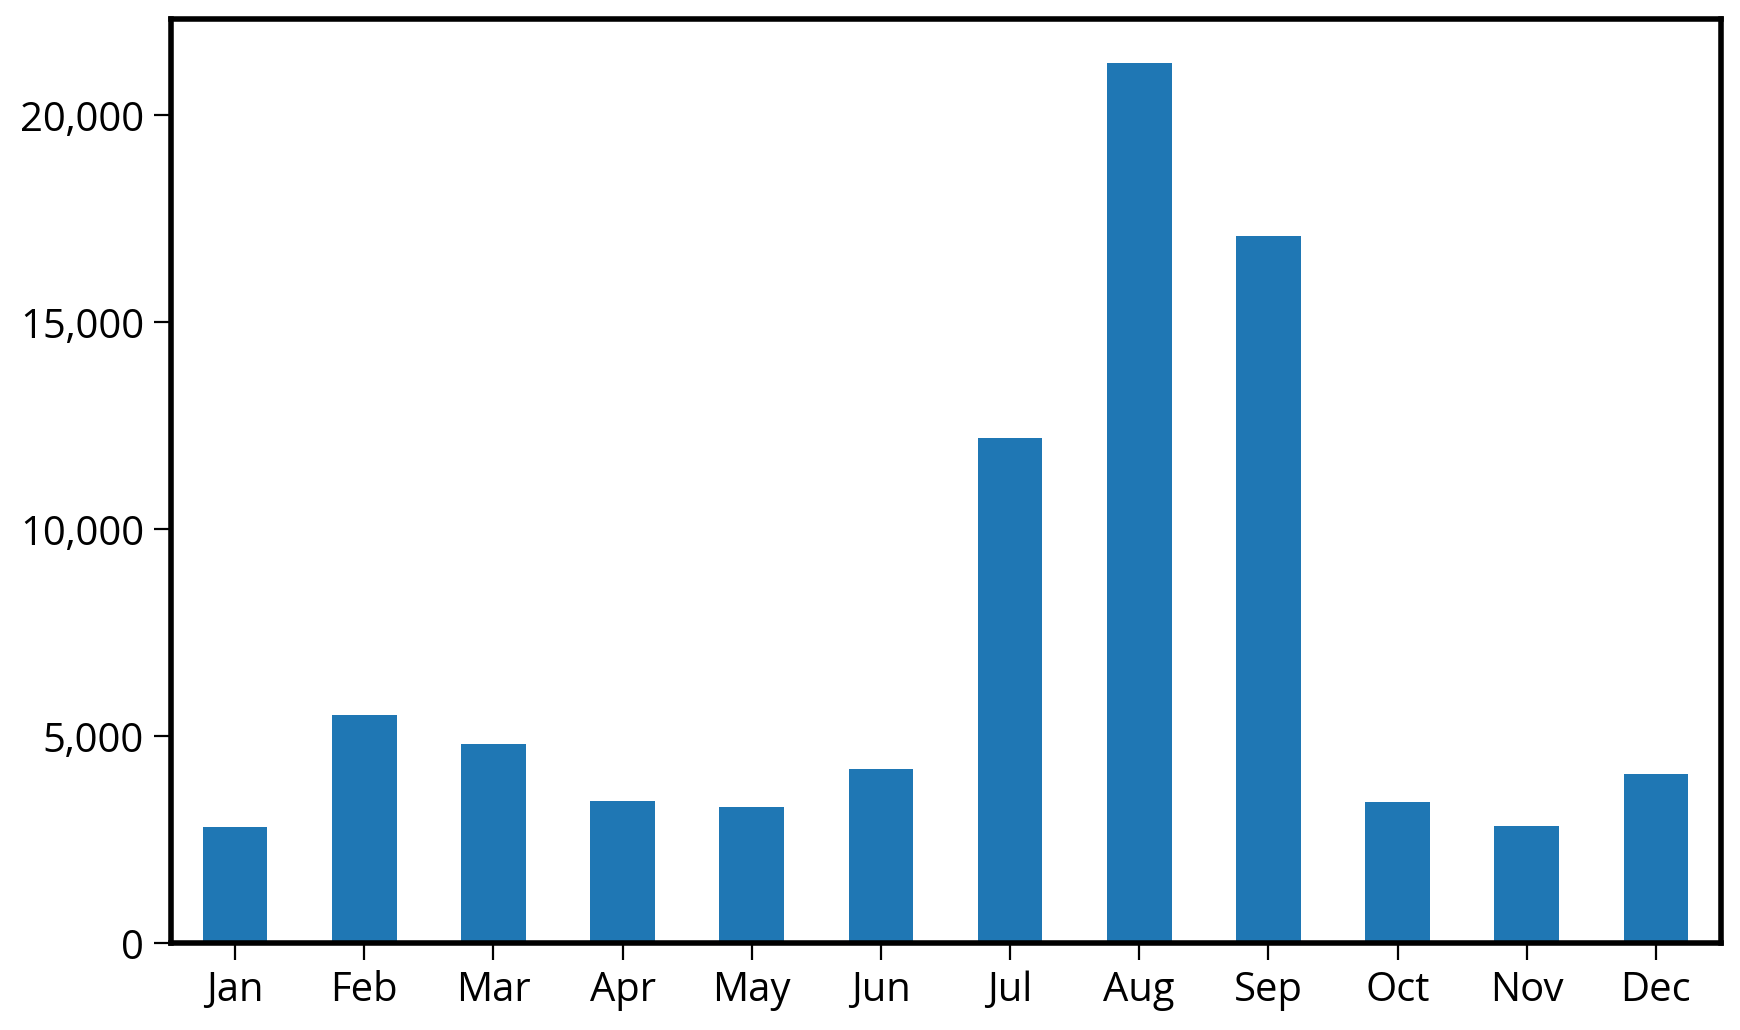

In [10]:
# Calculate monthly tweet totals
monthly_count = results['created_at'].dt.month.value_counts().sort_index()

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot
monthly_count.plot(kind='bar', ax=ax)

# Format
ax.set_xticks(range(0, 12))
ax.set_xticklabels([calendar.month_abbr[v] for v in range(1, 13)], rotation=0);
ax.set_yticks(np.arange(0, 25e3, 5e3))
ax.set_yticklabels([f"{v:,.0f}" for v in ax.get_yticks()]);

## 2. Filtering tweets by location

For more information, see this [tutorial](https://developer.twitter.com/en/docs/tutorials/filtering-tweets-by-location) on the Twitter documentation. Specifically, this tutorial includes [a number of examples](https://developer.twitter.com/en/docs/tutorials/filtering-tweets-by-location#usage-examples).

### 2A. Get tweets associated with a specific place

This will get all tweets geo-tagged as in Philadelphia.

To do this, use the `place` operator.

In [11]:
query = "#phillies -is:retweet place:Philadelphia"

tweets = client.search_all_tweets(
    query=query,
    tweet_fields=["created_at", "geo"],
    place_fields=["place_type", "geo"],
    expansions="geo.place_id",
    max_results=10,
)

# Get list of places from includes object
places = {p["id"]: p for p in tweets.includes['places']}

# Print out info
for tweet in tweets.data:
    print(tweet.id)
    print(tweet.text)
    if places[tweet.geo['place_id']]:
        place = places[tweet.geo['place_id']]
        print(place.full_name)
        
    print()

1577720416667406354
Leave your #MLB playoff predictions below #Phillies

https://t.co/VMh2r5nYVi

#Philly #PhiladelphiaPhillies #baseball #WorldSeries #Phila @ Citizens Bank Park https://t.co/LneDpYS7fy
Philadelphia, PA

1577495870123102209
lol the #Phillies almost getting no hit because they are all hungover from celebrating last night. #RingTheBell
Philadelphia, PA

1577469527906029575
This team is very hungover.  Get these @Phillies some IVs before Friday! #phillies #RingTheBell #wildcard https://t.co/lP3EsRYtsL
Philadelphia, PA

1577460327087685632
Ranger Danger 🙄 #Phillies
Philadelphia, PA

1577457127425069056
Guys. Give him a break. #Phillies https://t.co/iX0g9glAsC
Philadelphia, PA

1577455769900851200
Ranger seems hungover. This really isn’t fair. #Phillies
Philadelphia, PA

1577408477370191904
I hope audacy will put every phillies postseason game on 94.1 wip and not put some on 1210 wpht if the Eagles play at the same time. The days of the phillies on am radio in philly should

In [12]:
tweets.data[0].data

{'edit_history_tweet_ids': ['1577720416667406354'],
 'geo': {'coordinates': {'type': 'Point',
   'coordinates': [-75.16674663, 39.90584562]},
  'place_id': 'e4a0d228eb6be76b'},
 'id': '1577720416667406354',
 'created_at': '2022-10-05T18:00:34.000Z',
 'text': 'Leave your #MLB playoff predictions below #Phillies\n\nhttps://t.co/VMh2r5nYVi\n\n#Philly #PhiladelphiaPhillies #baseball #WorldSeries #Phila @ Citizens Bank Park https://t.co/LneDpYS7fy'}

### 2B. Search within a given radius 

This will get all tweets within 25 milies of the centroid of Philadelphia. 

To do this, use the `point_radius` operator. **Note:** maximum radius is 25 miles.

In [13]:
query = "#phillies -is:retweet point_radius:[-75.1651 39.9527 25mi]"

tweets = client.search_all_tweets(
    query=query,
    tweet_fields=["created_at", "geo"],
    place_fields=["place_type", "geo"],
    expansions="geo.place_id",
    max_results=10,
)

# Get list of places from includes object
places = {p["id"]: p for p in tweets.includes['places']}

# Print out info for each tweet
for tweet in tweets.data:
    
    # Print out the tweet info
    print(tweet.id)
    print(tweet.text)
    
    # Print out the place name
    if places[tweet.geo['place_id']]:
        place = places[tweet.geo['place_id']]
        print(place.full_name)
        
    print()

1577720416667406354
Leave your #MLB playoff predictions below #Phillies

https://t.co/VMh2r5nYVi

#Philly #PhiladelphiaPhillies #baseball #WorldSeries #Phila @ Citizens Bank Park https://t.co/LneDpYS7fy
Philadelphia, PA

1577669005099388934
Are we about to enter an #economic crisis?? Check the #Phillies winning the WS against economic volatility. Either way, let’s go Phillies!! https://t.co/3vBzpfu4tV
King of Prussia, PA

1577495870123102209
lol the #Phillies almost getting no hit because they are all hungover from celebrating last night. #RingTheBell
Philadelphia, PA

1577469527906029575
This team is very hungover.  Get these @Phillies some IVs before Friday! #phillies #RingTheBell #wildcard https://t.co/lP3EsRYtsL
Philadelphia, PA

1577462563201486848
Eleven years. #Phillies
From 2011: Our Cassie just loved Ryan Howard.
2022: In a Ryan Howard shersey enjoying Crab Fries. https://t.co/KfRCnDpVAB
Phoenixville, PA

1577460327087685632
Ranger Danger 🙄 #Phillies
Philadelphia, PA

15774575

In [14]:
places

{'e4a0d228eb6be76b': <Place id=e4a0d228eb6be76b full_name=Philadelphia, PA>,
 '23b12afb6fe7507a': <Place id=23b12afb6fe7507a full_name=King of Prussia, PA>,
 '6afb88feadd10a84': <Place id=6afb88feadd10a84 full_name=Phoenixville, PA>,
 '8ddb97278a8c8202': <Place id=8ddb97278a8c8202 full_name=Prospect Park, PA>,
 '0184f83510600ffd': <Place id=0184f83510600ffd full_name=Deptford, NJ>}

**Note:** to get more than 500 tweets, you must use the Paginator class.

### 2C. Geo search with Paginator

In [15]:
query_results = []
places = {}
max_results_per_request = 500 # must be between 10 and 500

# Use the paginator to loop over all available tweets in batches of 500
# This pulls 500 tweets at a time until all tweets from the time period are pulled
for i, tweets in enumerate(
    tw.Paginator(
        client.search_all_tweets,
        query="#phillies -is:retweet place_country:US",
        tweet_fields=["created_at", "geo"],
        place_fields=["place_type", "geo"],
        expansions="geo.place_id",
        max_results=max_results_per_request,
        start_time=start_date,
        end_time=end_date,
        limit=10
    )
):
    print(f"Response #{i+1}")
    
    # Store the tweet data
    # Note: 'tweets.data' is a list of the 500 tweets
    query_results += tweets.data
    
    # Keep track of all of the places
    for p in tweets.includes['places']:
        places[p["id"]] = p
   
    # Sleep for 1 second to avoid rate limit
    time.sleep(1)

Response #1
Response #2
Response #3
Response #4
Response #5
Response #6
Response #7
Response #8


In [16]:
def get_place_id(geo):
    try:
        return geo['place_id']
    except:
        return np.nan

In [17]:
# Convert to a dataframe and make a datetime column
query_results = pd.DataFrame(query_results)
query_results['created_at'] = pd.to_datetime(query_results['created_at'])

# Extract out the place id as its own column
query_results['place_id'] = query_results['geo'].apply(get_place_id)

In [18]:
query_results

,created_at,edit_history_tweet_ids,geo,id,text,place_id
0,2020-12-29 22:31:14+00:00,[1344048359720562689],{'place_id': 'dd9c503d6c35364b'},1344048359720562689,Phillies just got a reliever that can throw a ...,dd9c503d6c35364b
1,2020-12-29 19:23:56+00:00,[1344001223792463872],{'place_id': '70f5587b3e27a105'},1344001223792463872,@ripgriffinshow It’s not the #Phillies that’s ...,70f5587b3e27a105
2,2020-12-29 18:43:40+00:00,[1343991089355776000],{'place_id': '66c992a992d4a17a'},1343991089355776000,This is the help we’ve been looking for. Nice....,66c992a992d4a17a
3,2020-12-29 18:32:58+00:00,[1343988397002645509],{'place_id': 'dd9c503d6c35364b'},1343988397002645509,The #Phillies have made a trade acquiring P Jo...,dd9c503d6c35364b
4,2020-12-29 14:09:41+00:00,[1343922137552334849],{'place_id': '7142eb97ae21e839'},1343922137552334849,We’ve got a little NL East Roundtable coming u...,7142eb97ae21e839
...,...,...,...,...,...,...
3631,2020-01-01 05:22:03+00:00,[1212242560816680960],"{'coordinates': {'type': 'Point', 'coordinates...",1212242560816680960,#HappyNewYear #HTTR #LakeShow #Phillies https:...,00ca00906ca4c6d4
3632,2020-01-01 05:12:05+00:00,[1212240051381374977],{'place_id': '01addd4521cf35e0'},1212240051381374977,2020 starts with everyone but me passed out! ...,01addd4521cf35e0
3633,2020-01-01 01:51:16+00:00,[1212189513981677569],{'place_id': 'a612c69b44b2e5da'},1212189513981677569,@TheCUTCH22 happy New Years Cutch! See you in ...,a612c69b44b2e5da
3634,2020-01-01 01:24:00+00:00,[1212182652297580544],{'place_id': 'ed2f91f4683ea25f'},1212182652297580544,NL EAST team correspondents (4/8):\n@berrys_ba...,ed2f91f4683ea25f


In [19]:
# Convert places dict to a dataframe
places_df = []

# Loop over each place_id
for place_id in places:
    
    # Geo info for each place
    values = places[place_id]
    
    # Convert to a dict
    row = dict(values)
    
    # Save it
    places_df.append(row)
    
# Initialize the dataframe
places_df = pd.DataFrame(places_df).rename(columns={"id": "place_id"})

In [20]:
places_df.head(50)

,full_name,geo,place_id,place_type
0,"Pennsylvania, USA","{'type': 'Feature', 'bbox': [-80.519851, 39.71...",dd9c503d6c35364b,admin
1,"Victoria, TX","{'type': 'Feature', 'bbox': [-97.045657, 28.70...",70f5587b3e27a105,city
2,"Owensboro, KY","{'type': 'Feature', 'bbox': [-87.211826, 37.71...",66c992a992d4a17a,city
3,"Georgia, USA","{'type': 'Feature', 'bbox': [-85.605166, 30.35...",7142eb97ae21e839,admin
4,"Penndel, PA","{'type': 'Feature', 'bbox': [-74.924109, 40.14...",4ebcf64484051ec2,city
5,"Philadelphia, PA","{'type': 'Feature', 'bbox': [-75.280284, 39.87...",e4a0d228eb6be76b,city
6,"State College, PA","{'type': 'Feature', 'bbox': [-77.917295, 40.74...",22c613c36f32f0d1,city
7,"Roseville, CA","{'type': 'Feature', 'bbox': [-121.385009, 38.7...",38109314e8d0ee2f,city
8,"Forest Park, IL","{'type': 'Feature', 'bbox': [-87.833698, 41.85...",97d83d40844c1807,city
9,"Ohio, USA","{'type': 'Feature', 'bbox': [-84.8203089, 38.4...",de599025180e2ee7,admin


In [21]:
# Merge in the places geo data and the query results
query_results_final = query_results.merge(places_df, how='left', on='place_id')

In [22]:
query_results_final

,created_at,edit_history_tweet_ids,geo_x,id,text,place_id,full_name,geo_y,place_type
0,2020-12-29 22:31:14+00:00,[1344048359720562689],{'place_id': 'dd9c503d6c35364b'},1344048359720562689,Phillies just got a reliever that can throw a ...,dd9c503d6c35364b,"Pennsylvania, USA","{'type': 'Feature', 'bbox': [-80.519851, 39.71...",admin
1,2020-12-29 19:23:56+00:00,[1344001223792463872],{'place_id': '70f5587b3e27a105'},1344001223792463872,@ripgriffinshow It’s not the #Phillies that’s ...,70f5587b3e27a105,"Victoria, TX","{'type': 'Feature', 'bbox': [-97.045657, 28.70...",city
2,2020-12-29 18:43:40+00:00,[1343991089355776000],{'place_id': '66c992a992d4a17a'},1343991089355776000,This is the help we’ve been looking for. Nice....,66c992a992d4a17a,"Owensboro, KY","{'type': 'Feature', 'bbox': [-87.211826, 37.71...",city
3,2020-12-29 18:32:58+00:00,[1343988397002645509],{'place_id': 'dd9c503d6c35364b'},1343988397002645509,The #Phillies have made a trade acquiring P Jo...,dd9c503d6c35364b,"Pennsylvania, USA","{'type': 'Feature', 'bbox': [-80.519851, 39.71...",admin
4,2020-12-29 14:09:41+00:00,[1343922137552334849],{'place_id': '7142eb97ae21e839'},1343922137552334849,We’ve got a little NL East Roundtable coming u...,7142eb97ae21e839,"Georgia, USA","{'type': 'Feature', 'bbox': [-85.605166, 30.35...",admin
...,...,...,...,...,...,...,...,...,...
3631,2020-01-01 05:22:03+00:00,[1212242560816680960],"{'coordinates': {'type': 'Point', 'coordinates...",1212242560816680960,#HappyNewYear #HTTR #LakeShow #Phillies https:...,00ca00906ca4c6d4,"Bensalem, PA","{'type': 'Feature', 'bbox': [-74.994551, 40.04...",city
3632,2020-01-01 05:12:05+00:00,[1212240051381374977],{'place_id': '01addd4521cf35e0'},1212240051381374977,2020 starts with everyone but me passed out! ...,01addd4521cf35e0,"Four Corners, FL","{'type': 'Feature', 'bbox': [-81.707927, 28.26...",city
3633,2020-01-01 01:51:16+00:00,[1212189513981677569],{'place_id': 'a612c69b44b2e5da'},1212189513981677569,@TheCUTCH22 happy New Years Cutch! See you in ...,a612c69b44b2e5da,"Arizona, USA","{'type': 'Feature', 'bbox': [-114.818269, 31.3...",admin
3634,2020-01-01 01:24:00+00:00,[1212182652297580544],{'place_id': 'ed2f91f4683ea25f'},1212182652297580544,NL EAST team correspondents (4/8):\n@berrys_ba...,ed2f91f4683ea25f,"Longmeadow, MA","{'type': 'Feature', 'bbox': [-72.606307, 42.02...",city
